## Convolutional Neural Networks (CNNs)

In this notebook, we will learn to use pytorch's autograd. We will not be implementing gradient computations anymore. First, we will re-implement FashionMNIST Classification using pytorch. Then we will perform FashionMNIST Classification using the LeNet convolutional neural network. We will also be using GPUs for the first time to accelerate computations.


### 1. Using the GPU with pytorch


This code will show you how easy is to do GPU computations in pytorch, and how fast they can be. Note that the first time you run this code there might be some delay in starting up the GPU, so it might actually be slower, so try running this cell multiple times.

In [1]:
import torch
import time

# Let's create two matrices of size dxd and full of random values.
d = 5000
a = torch.rand(d, d)
b = torch.rand(d, d)

# Compute a multiplication between the two matrices in CPU.
start_time = time.time()
output = torch.mm(a,b)  # Regular multiplication in CPU.
cpu_time = time.time() - start_time
print('CPU-time {0:.6f}s'.format(cpu_time))

# Compute a multiplication between the two matrices in GPU.
start_time = time.time()
a = a.cuda() # Move to GPU.
b = b.cuda() # Move to GPU.
output = torch.mm(a,b)  # Multiplication happens in GPU.
gpu_time = time.time() - start_time
print('GPU-time {0:.6f}s\n'.format(gpu_time))

print('CPU was {0:.2f}x times the GPU time'.format(cpu_time / gpu_time))


CPU-time 1.419769s
GPU-time 8.772846s

CPU was 0.16x times the GPU time


Trry experimenting with different values of $d$ and check what kind of improvements in the speed you can get on GPU compared to CPU.

### 2. Mini-batch SGD on FashionMNIST using pytorch nn's package.


In this section we will train a two-layer neural network using pytorch's nn package. First, we will define, the model and its operations. Then we will train the model using mini-batch gradient descent.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class TwoLayerNN(nn.Module):
    def __init__(self):
        super(TwoLayerNN, self).__init__()
        self.linear1 = nn.Linear(1 * 28 * 28, 512)
        self.linear2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = x.view(batchSize, 1 * 28 * 28)
        z = F.relu(self.linear1(x))
        return self.linear2(z)    

The training code is similar to the code used before.

In [7]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import torch.optim as optim

# Removes, the need to call F.to_image ourselves.
# Also, please look up what transforms.Normalize does.
# transform = transforms.Compose([transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), 
#                                                     (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

# Load the training, and validation datasets.
trainset = FashionMNIST(root = './data', train = True, transform = transform, download = True)
valset = FashionMNIST(root = './data', train = False, transform = transform, download = True)

# Pytorch DataLoader for iterating over batches.
batchSize = 100

# Create the model.
model = TwoLayerNN()
loss_fn = nn.CrossEntropyLoss()

# Define a learning rate. 
learningRate = 5e-2

# Optimizer.
optimizer = optim.SGD(model.parameters(), lr = learningRate, 
                      momentum = 0.9, weight_decay = 1e-4)

In [8]:
def train_model(model, loss_fn, batchSize, trainset, valset, optimizer):
    # Shuffling is needed in case dataset is not shuffled by default.
    train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                              batch_size=batchSize,
                                              shuffle=True)
    # We don't need to bach the validation set but let's do it anyway.
    val_loader = torch.utils.data.DataLoader(dataset=valset,
                                            batch_size=batchSize,
                                            shuffle=False)  # No need.
    # Define number of epochs.
    N = 5
    # log accuracies and losses.
    train_accuracies = []; val_accuracies = []
    train_losses = []; val_losses = []
    # GPU enabling.
    model = model.cuda()
    loss_fn = loss_fn.cuda()
    # Training loop. Please make sure you understand every single line of code below.
    # Go back to some of the previous steps in this lab if necessary.
    for epoch in range(0, N):
        correct = 0.0
        cum_loss = 0.0

      # Make a pass over the training data.
        model.train()
        for (i, (inputs, labels)) in enumerate(train_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Forward pass. (Prediction stage)
            scores = model(inputs)
            loss = loss_fn(scores, labels)

            # Count how many correct in this batch.
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == labels).sum().item()
            cum_loss += loss.item()

            # Zero the gradients in the network.
            optimizer.zero_grad()

            # Backward pass. (Gradient computation stage)
            loss.backward()

            # Parameter updates (SGD step) -- if done with torch.optim!
            optimizer.step()

          # Parameter updates (SGD step) -- if done manually!
          # for param in model.parameters():
          #   param.data.add_(-learningRate, param.grad)

          # Logging the current results on training.
            if (i + 1) % 100 == 0:
                print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batchSize)))

        train_accuracies.append(correct / len(trainset))
        train_losses.append(cum_loss / (i + 1))   

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        model.eval()
        for (i, (inputs, labels)) in enumerate(val_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Forward pass. (Prediction stage)
            scores = model(inputs)
            cum_loss += loss_fn(scores, labels).item()

            # Count how many correct in this batch.
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == labels).sum().item()

        val_accuracies.append(correct / len(valset))
        val_losses.append(cum_loss / (i + 1))

        # Logging the current results on validation.
        print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
            (epoch, cum_loss / (i + 1), correct / len(valset)))

train_model(model, loss_fn, batchSize, trainset, valset, optimizer)


Train-epoch 0. Iteration 00100, Avg-Loss: 0.7469, Accuracy: 0.7333
Train-epoch 0. Iteration 00200, Avg-Loss: 0.6369, Accuracy: 0.7703
Train-epoch 0. Iteration 00300, Avg-Loss: 0.5842, Accuracy: 0.7886
Train-epoch 0. Iteration 00400, Avg-Loss: 0.5493, Accuracy: 0.8013
Train-epoch 0. Iteration 00500, Avg-Loss: 0.5271, Accuracy: 0.8093
Train-epoch 0. Iteration 00600, Avg-Loss: 0.5120, Accuracy: 0.8145
Validation-epoch 0. Avg-Loss: 0.4374, Accuracy: 0.8421
Train-epoch 1. Iteration 00100, Avg-Loss: 0.3897, Accuracy: 0.8552
Train-epoch 1. Iteration 00200, Avg-Loss: 0.4036, Accuracy: 0.8517
Train-epoch 1. Iteration 00300, Avg-Loss: 0.4049, Accuracy: 0.8534
Train-epoch 1. Iteration 00400, Avg-Loss: 0.4026, Accuracy: 0.8542
Train-epoch 1. Iteration 00500, Avg-Loss: 0.4013, Accuracy: 0.8540
Train-epoch 1. Iteration 00600, Avg-Loss: 0.3991, Accuracy: 0.8543
Validation-epoch 1. Avg-Loss: 0.4267, Accuracy: 0.8399
Train-epoch 2. Iteration 00100, Avg-Loss: 0.3803, Accuracy: 0.8593
Train-epoch 2. Iter

We achieved an accuracy of 86% and achieved 83% in only one epoch. Our model is very similar to the models we implemented before, but now we are using SGD with regularization (weightDecay), and momentum updates (using the history of previous gradients) in order to update the parameters. We also have generic train_model function that is independent of the model passed as a parameter. We no longer need to focus on this training loop, and instead can concentrate in the design of models. 

### 3. Convolutional Neural Network -- LeNet


We are close to implementing a neural network, we can accomplish this by stacking a linear operation on top of a Rectified Linear Unit (ReLU) activation, another linear operation, and the softmax + negative log likelihood loss. This is all it takes to create simple neural network with one hidden layer. First, let's implement the ReLU layer as we implemented the linear layer. 

In [9]:
# Insipired on LeNet, first proposed in: 
# https://ieeexplore.ieee.org/abstract/document/726791
# PDF: http://www.cs.virginia.edu/~vicente/deeplearning/readings/lecun1998.pdf
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # Convolutional layers.
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        
        # Linear layers.
        self.fc1 = nn.Linear(64*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Conv1 + ReLU + MaxPooling.
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        
        # Conv2 + ReLU + MaPooling.
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        
        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1) 
        
        # Linear layer + ReLU.
        out = F.relu(self.fc1(out))
        # Linear layer + ReLU.
        out = F.relu(self.fc2(out))
        # A final linear layer at the end.
        out = self.fc3(out)
       
        # We will not add Softmax here because nn.CrossEntropy does it.
        # Read the documentation for nn.CrossEntropy.
        return out

cnn_model = LeNet()

# print(cnn_model) # It shows the network structure.

# see: ADAM: A Method for Stochastic Optimization.
# https://arxiv.org/pdf/1412.6980.pdf
optimizer = optim.Adam(cnn_model.parameters(), lr = 1e-3)

train_model(cnn_model, loss_fn, batchSize, trainset, valset, optimizer)

Train-epoch 0. Iteration 00100, Avg-Loss: 0.9444, Accuracy: 0.6555
Train-epoch 0. Iteration 00200, Avg-Loss: 0.7648, Accuracy: 0.7184
Train-epoch 0. Iteration 00300, Avg-Loss: 0.6716, Accuracy: 0.7522
Train-epoch 0. Iteration 00400, Avg-Loss: 0.6112, Accuracy: 0.7756
Train-epoch 0. Iteration 00500, Avg-Loss: 0.5690, Accuracy: 0.7906
Train-epoch 0. Iteration 00600, Avg-Loss: 0.5399, Accuracy: 0.8015
Validation-epoch 0. Avg-Loss: 0.3804, Accuracy: 0.8616
Train-epoch 1. Iteration 00100, Avg-Loss: 0.3661, Accuracy: 0.8684
Train-epoch 1. Iteration 00200, Avg-Loss: 0.3559, Accuracy: 0.8712
Train-epoch 1. Iteration 00300, Avg-Loss: 0.3511, Accuracy: 0.8730
Train-epoch 1. Iteration 00400, Avg-Loss: 0.3422, Accuracy: 0.8752
Train-epoch 1. Iteration 00500, Avg-Loss: 0.3344, Accuracy: 0.8777
Train-epoch 1. Iteration 00600, Avg-Loss: 0.3307, Accuracy: 0.8788
Validation-epoch 1. Avg-Loss: 0.3227, Accuracy: 0.8839
Train-epoch 2. Iteration 00100, Avg-Loss: 0.2822, Accuracy: 0.8971
Train-epoch 2. Iter

Now we have a working model that classifies images at 90% accuracy. Moreover, this simple convolutional neural network matches the accuracy of the shallow classifier on the very first epoch.

You can find a list of results that people have obtained on FashionMNIST using more sophisticated neural networks here, including some accuracies slightly above 95%: https://github.com/zalandoresearch/fashion-mnist

### 4. Using a Pre-Trained Convolutional Neural Network -- Inception_v3



In this section we will load a network pretrained on the ImageNet ILSVRC dataset, which has RGB images annotated with one label out of a vocabulary 1000 categories, and use it to make predictions on new images. We will use the Inception_v3 neural network proposed by Google, a successor of their GoogLeNet network which we will analyze during class.

In [10]:
import torchvision.models as models

# Download list of 1000 categories for the ILSVRC task in right order.
!wget -nc -q http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json
  
# Load the pre-trained model from the torchvision package.
# https://arxiv.org/abs/1512.00567  # Re-thinking the Inception Architecture.
cnn_model = models.inception_v3(pretrained = True)
cnn_model.eval();  # Set in evaluation mode! In this case it matters.

# print(resnet) # It shows the network structure.
# You should instead look at source code here:
# https://pytorch.org/docs/stable/_modules/torchvision/models/inception.html#inception_v3

'wget' is not recognized as an internal or external command,
operable program or batch file.
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to C:\Users\Saurav/.torch\models\inception_v3_google-1a9a5a14.pth

0it [00:00, ?it/s]
2318336it [00:00, 23175038.81it/s]
4513792it [00:00, 22639703.78it/s]
6922240it [00:00, 23037069.55it/s]
9986048it [00:00, 24884874.26it/s]
12681216it [00:00, 25185275.02it/s]
15417344it [00:00, 25795616.88it/s]
18178048it [00:00, 26230543.66it/s]
20791296it [00:00, 26001129.69it/s]
23601152it [00:00, 26483809.84it/s]
26173440it [00:01, 21727506.93it/s]
30441472it [00:01, 25367463.68it/s]
33759232it [00:01, 27190616.16it/s]
36724736it [00:01, 27569502.60it/s]
39657472it [00:01, 27429164.39it/s]
42524672it [00:01, 26831868.35it/s]
45588480it [00:01, 27570411.26it/s]
48414720it [00:01, 27328996.22it/s]
51527680it [00:01, 28180917.67it/s]
54616064it [00:02, 28627488.41it/s]
57516032it [00:02, 27127413.11it/s]
60268544it [00:02, 26

Now we will use the model, but we have to be careful to use the exact same pre-processing steps for the input as it was done during training. I am providing the code here below that pre-processes images in the same way as this model was trained.

In [11]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import json, io, requests, string

# 1. Define the appropriate image pre-processing function.
# This has to be the preprocessing function used during training. 
preprocessFn = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.CenterCrop(224), # 2. Crop the center 224x224 pixels.
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in 
                   json.load(open('imagenet_class_index.json')).items()}

# 3. Read image from URL into a PIL image type.
# This is a picture of a cat I took at the 
# Edgar Allan Poe's museum in Richmond, VA.
# Try other images!
img_url = 'http://www.cs.virginia.edu/~vicente/vision/black-cat.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# 4. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
input_img =  preprocessFn(img_pil).unsqueeze(0)
predictions = cnn_model(input_img)

# 5. Decode the top 5 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
probs = (-probs).numpy()[0][:5]; indices = indices.numpy()[0][:10]
preds = ['P[\"' + imagenetClasses[idx] + '\"] = ' + ('%.6f' % prob) \
         for (prob, idx) in zip(probs, indices)]

# 6. Show image and predictions
plt.title('\n'.join(preds))
plt.imshow(img_pil); plt.grid(False); plt.axis('off');

FileNotFoundError: [Errno 2] No such file or directory: 'imagenet_class_index.json'

### 5. Fine-tuning a Pre-trained Model for a Different Task (and Dataset) 



Pre-trained models can be adapted to other tasks, by lightly re-training them (with a small learning rate), and replacing some of the last layers with custom layers for a different task. This process is usually referred as fine-tuning a network, and is the usual way of using neural networks for many applications. In this assignment we will be using the MIT Indoor Scenes Dataset introduced at CVPR 2009 http://web.mit.edu/torralba/www/indoor.html. This dataset has more than 15 thousand images belonging to 67 categories of indoor scenes (e.g. meeting room, dining room, toy store, restaurant, etc). 


**Preparing the Data - Indoor Place Recognition**


When the MIT researchers Ariadna Quattoni and Antonio Torralba performed this work, they only used 67 \* 80 = 5360 images for training, and 67 \* 20 = 1340 images for testing, but we will use all the images instead. The tar file with all the images is about 2.4GB but we already downloaded, resized and cropped images to a 256x256 resolution for a total of 235MB. We also separated the images into three groups MIT-test, which is the same test data used in the original work, and [train-uva.tar.gz](https://www.cs.virginia.edu/~vicente/deeplearning/train-uva.tar.gz), [val-uva.tar.gz](https://www.cs.virginia.edu/~vicente/deeplearning/val-uva.tar.gz) which are the rest of the images sub-divided into training and validation sets. We will not use the MIT-test images as this is the test set, so I am not providing the test images at all. The images inside these tar-files were already arranged in the format required to use the [torchvision.datasets.ImageFolder](https://pytorch.org/docs/stable/_modules/torchvision/datasets/folder.html#ImageFolder) class.

In [0]:
# First download the data files.
!wget -nc https://www.cs.virginia.edu/~vicente/deeplearning/val-uva.tar.gz
!wget -nc https://www.cs.virginia.edu/~vicente/deeplearning/train-uva.tar.gz
!tar xf val-uva.tar.gz
!tar xf train-uva.tar.gz

--2019-02-18 01:59:42--  https://www.cs.virginia.edu/~vicente/deeplearning/val-uva.tar.gz
Resolving www.cs.virginia.edu (www.cs.virginia.edu)... 128.143.67.11
Connecting to www.cs.virginia.edu (www.cs.virginia.edu)|128.143.67.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17513967 (17M) [application/x-gzip]
Saving to: ‘val-uva.tar.gz’

val-uva.tar.gz      100%[===================>]  16.70M  7.05MB/s    in 2.4s    

2019-02-18 01:59:45 (7.05 MB/s) - ‘val-uva.tar.gz’ saved [17513967/17513967]

--2019-02-18 01:59:48--  https://www.cs.virginia.edu/~vicente/deeplearning/train-uva.tar.gz
Resolving www.cs.virginia.edu (www.cs.virginia.edu)... 128.143.67.11
Connecting to www.cs.virginia.edu (www.cs.virginia.edu)|128.143.67.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170947073 (163M) [application/x-gzip]
Saving to: ‘train-uva.tar.gz’

train-uva.tar.gz    100%[===================>] 163.03M  15.1MB/s    in 12s     

2019-02-18 02:00:0

**Data Augmentation: ** We often want to apply different transformations during training compared to testing to augment the data during training. In pytorch we can achieve this with minimal modifications by specifying a slightly different transformation function during training. However, one has to be careful that both training and testing images are subject to similar transformations.

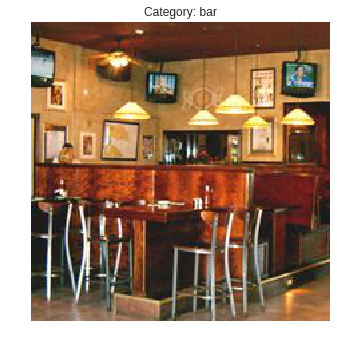

In [0]:
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

train_transform = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.RandomCrop(224), # 2. Crop random square of 224x224 pixels.
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])])

test_transform = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.CenterCrop(224), # 2. Crop center square of 224x224 pixels.
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder("train-uva", train_transform)
val_dataset = datasets.ImageFolder("val-uva", test_transform)

# Try seeing other images in this dataset.
# If you run this cell multiple times, you will perhaps notice
# that the images are indeed slightly shifted (due to random cropping),
# or they are mirrored (due to the horizonal flipping).
# Only for the train_dataset this will happen.
my_image, my_label = train_dataset[1234]

# Show the image and its label.
plt.figure()
plt.title("Category: " + train_dataset.classes[my_label])
# Undo normalization of the pixel values.
for t, m, s in zip(my_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
  t.mul_(s).add_(m)
# Re-arrange dimensions so it is height x width x channels.
plt.imshow(my_image.transpose(0,2).transpose(0,1));
plt.grid(False); plt.axis('off');

The rest of this tutorial is unfinished and is to be completed as part of the assignment, instructions follow below.

## Assignment Questions [10pts]

### 1. Fine-tuning [3pts]: 
Fine-tune the Alexnet model from (Krizhevsky, Sustkever, Hinton 2012) for Indoor Scene Recognition using the MIT dataset, and provide a training/validation plot for losses and accuracy. The idea of "fine-tuning" is to train the network only slightly (small learning rate) so that it learns the new task but doesn't completely over-writes the previous weights. This is usually referred to as "fine-tuning". What is a reasonable accuracy on this dataset? You can check this paper from 2014 by Zhou et al which contains more recent results  http://places.csail.mit.edu/places_NIPS14.pdf. It seems pre-training on Imagenet should lead to 56% accuracy using a version of Alexnet, so this is the expectation here. You have to select optimizer, batch size, etc, to make this happen.

In [0]:
import torchvision.models as models

cnn_model = models.alexnet(pretrained = True) # no pretraining
# Feel free to replace the classification layer differently than this.
# See: https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py
cnn_model.classifier = nn.Linear(9216, 67) # replace classification layer.
cnn_model.eval();

Write your code below, feel free to either modify or just use the train_model function defined earlier in this notebook. The above cell allocates a lot of memory so it is better to write the training code in the cell below.

In [0]:
# Your training code.

### 2. Deep Features [3pts]:
Fine-tuning the Inception_v3 network would take a lot of GPU memory and computing time. Another alternative to use a pretrained network is to just use it as a source of features. The idea is to use an intermediate ouput of a pre-trained network to convert images into vectors. Typically the output vector in the layer before the final predictions is used for this purpose. Once the images in both the training set are converted into vectors, we can try a linear + softmax classifier or any other shallow classifier. Try using either the pretrained Inception_v3 network or the pretrained Resnet50 network for this purpose, and train a classifier based on these "deep features". For this part it is sufficient if you report your final validation accuracy. Use the same data and task as in Question 1.

In [0]:
# Your code for pre-computing the deep features goes here.

In [0]:
# Your code for training your shallow classifier goes here.

### 3. Batch-Normalization + Max-Pool Removal [2pts]. 
Below is the implementation of Alexnet included in pytorch, after this network was released in NeurIPS 2012, several other ideas regarding individual layers were introduced to make models better. In this section, modify the code of Alexnet so that it uses BatchNormalization layers (Ioffe and Szegedy https://arxiv.org/abs/1502.03167) after each convolutional layer. You don't need to implement a BatchNorm layer, just use the one included in Pytorch. In another network such as the VGG Network (https://arxiv.org/abs/1409.1556), it was shown that one does not need to use max-pooling layers after all convolutional layers, remove all the max-pooling layers of Alexnet so that this is still a valid network. **Note: **You don't need to train this model.

In [0]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

# TEST: This should still work after the two required modifications.
# The output should be a tensor of size batchSize x numPredictions
mock_input_batch = torch.zeros(10, 3, 224, 224).normal_(0, 0.01)

alexnet = AlexNet()
alexnet.eval()

print('input_batch.shape:', mock_input_batch.shape)
scores = alexnet(mock_input_batch)
print('scores.shape:', scores.shape)

input_batch.shape: torch.Size([10, 3, 224, 224])
scores.shape: torch.Size([10, 1000])


### 4. Skip-Connections (Residuals) + Inception Layers [2pts]. 
Below is the implementation of Alexnet included in pytorch, after this network was released in NeurIPS 2012, several other ideas regarding architectural changes were introduced to make models better. Modify the code of AlexNet below so that it has a skip connection between the third and fifth convolutional layer (see ResNet by He et al https://arxiv.org/abs/1512.03385 ). Additionally, replace the second convolutional layer with an Inception Layer that has three branches, each using filters of different size (see Inception_v3 by Szegedy et al https://arxiv.org/abs/1512.00567 ). **Note: **You don't need to train this model.

In [0]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

# TEST: This should still work after the two required modifications.
# The output should be a tensor of size batchSize x numPredictions
mock_input_batch = torch.zeros(10, 3, 224, 224).normal_(0, 0.01)

alexnet = AlexNet()
alexnet.eval()

print('input_batch.shape:', mock_input_batch.shape)
scores = alexnet(mock_input_batch)
print('scores.shape:', scores.shape)

input_batch.shape: torch.Size([10, 3, 224, 224])
scores.shape: torch.Size([10, 1000])
